# 3D Poission：
$$\frac{\partial^2u}{\partial x^2}+\frac{\partial^2u}{\partial y^2}+\frac{\partial^2u}{\partial z^2}+1=0$$
解的形式：
$$\frac{1-x^2-y^2-z^2}{6}$$
边界：
$$x^2+y^2+z^2 \le 1$$
边界条件：
$$u(x,y,z)=0$$
初始条件：无

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.




In [2]:
# Problem parameters:
x_center, y_center, z_center = 0,0,0
r = 1

lr = 1e-3
iterations = 20000
data_path_name = "./Poission/poission4_3d"
input_num = 3
net_node = 50
layers = 3

num_domain=256 # 用于描述域内的点的数量
num_boundary=32 # 用于描述边界上的点的数量
num_test=256 # 用于描述测试点的数量

In [3]:
## PS：如果没有测试集的话可以用gen_testdata生成，训练不需要数据集
def gen_testdata(path_name):
    """Import and preprocess the dataset with the exact solution."""
    data = np.load(path_name+".npz")
    # Obtain the values for t, x, and the excat solution:
    x, y, z, exact = data["x1"],data["x2"], data["x3"], data["usol"]
    # Process the data and flatten it out (like labels and features):
    xx, yy, zz= np.meshgrid(x, y, z) # meshgrid：生成网格点坐标矩阵
    X = np.vstack((np.ravel(xx), np.ravel(yy),np.ravel(zz))).T # ravel：将多维数组降为一维
    y = exact.flatten()[:, None]
    return X, y

# 定义PDE
def pde(x, y):
    """
        Expresses the PDE residual of the heat equation.
        在这里修改pde的内容, 从而获得解。让等式右侧为0
    """
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    dy_zz = dde.grad.hessian(y, x, i=2, j=2)
    return  -dy_xx -dy_yy -dy_zz- 1

def func(x):
    return (np.abs(1 - np.linalg.norm(x, axis=1, keepdims=True) ** 2))/6 # 二维÷4，三维÷6

In [4]:
geom = dde.geometry.Sphere([x_center, y_center, z_center], r)
bc = dde.icbc.DirichletBC(geom, func, lambda _,on_boundary:on_boundary) # 直接使用func和令边界值为0相同

# 数据作为model的输入
data = dde.data.PDE(
    geom, # 用于描述空间和时间的几何形状
    pde, # 用于描述PDE的函数
    [bc], # 用于描述边界和初始条件的列表
    num_domain=num_domain, # 用于描述域内的点的数量
    num_boundary=num_boundary, # 用于描述边界上的点的数量
    num_test=num_test, # 用于描述测试点的数量
)
# 定义网络，修改第1和最后一个参数，以及选择tanh或sigmoid作为激活函数
net = dde.nn.FNN([input_num] + [net_node] * layers + [1], "tanh", "Glorot normal")# 变量，神经元，隐藏层，输出，
    # Glorot normal: 一种初始化方法
model = dde.Model(data, net)


In [5]:
# 训练模型：先利用Adam进行训练，然后用L-BFGS进行训练
#快速降低损失
model.compile("adam", lr=lr) # 选择优化器和学习率
model.train(iterations=iterations) # 训练模型，迭代次数20000止
#精细调整
model.compile("L-BFGS") # 选择优化器
losshistory, train_state = model.train() # 训练模型

Compiling model...
Building feed-forward neural network...
'build' took 0.101740 s



/root/miniconda3/lib/python3.8/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-08-15 20:35:18.775491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 20:35:19.920390: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-15 20:35:19.920967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30279 MB memory:  -> device: 0, name: T

'compile' took 2.096668 s

Training model...



2023-08-15 20:35:20.786786: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-08-15 20:35:20.925395: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f5834009850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-15 20:35:20.925444: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-08-15 20:35:20.939903: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-15 20:35:22.475317: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [1.00e+00, 5.15e-03]    [1.00e+00, 5.15e-03]    []  
1000      [9.19e-05, 6.82e-05]    [7.47e-05, 6.82e-05]    []  
2000      [2.96e-05, 1.80e-06]    [2.61e-05, 1.80e-06]    []  
3000      [1.70e-05, 1.91e-06]    [1.62e-05, 1.91e-06]    []  
4000      [1.28e-05, 8.69e-07]    [1.24e-05, 8.69e-07]    []  
5000      [1.02e-05, 8.70e-07]    [1.01e-05, 8.70e-07]    []  
6000      [8.79e-06, 1.02e-06]    [8.78e-06, 1.02e-06]    []  
7000      [7.36e-06, 9.44e-07]    [7.27e-06, 9.44e-07]    []  
8000      [6.31e-06, 3.94e-06]    [6.24e-06, 3.94e-06]    []  
9000      [5.54e-06, 3.66e-06]    [5.56e-06, 3.66e-06]    []  
10000     [4.55e-06, 8.15e-07]    [4.45e-06, 8.15e-07]    []  
11000     [3.87e-06, 7.50e-07]    [3.77e-06, 7.50e-07]    []  
12000     [4.61e-06, 2.13e-04]    [4.84e-06, 2.13e-04]    []  
13000     [2.66e-06, 6.33e-07]    [2.54e-06, 6.33e-07]    []  
14000     [2.19e-06, 5.89e-07]    [2.09e-06, 5.8

2023-08-15 20:35:51.721133: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Step      Train loss              Test loss               Test metric
20000     [5.36e-07, 3.91e-07]    [5.95e-07, 3.91e-07]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000001
  Number of iterations: 7
  Number of functions evaluations: 26
20026     [4.63e-07, 2.81e-07]    [4.72e-07, 2.81e-07]    []  

Best model at step 20026:
  train loss: 7.44e-07
  test loss: 7.53e-07
  test metric: []

'train' took 3.117436 s



Saving loss history to /root/PINN/loss.dat ...
Saving training data to /root/PINN/train.dat ...
Saving test data to /root/PINN/test.dat ...


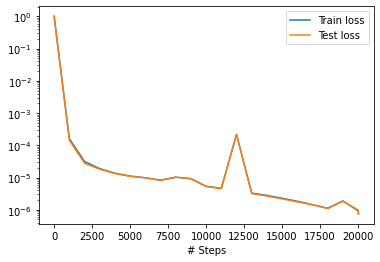

Mean Squared Error: 3.24544046734107e-06
Mean Squared Error Variance: 2.8463376514223968e-06


In [6]:
# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True) # 保存损失函数图像
X, y_true = gen_testdata(data_path_name) # 生成测试数据
y_pred = model.predict(X) # 预测

# 计算均方误差
mse = dde.metrics.mean_squared_error(y_true, y_pred)
print("Mean Squared Error:", mse)
# 计算均方误差的方差
mse_variance = np.var(y_true - y_pred)
print("Mean Squared Error Variance:", mse_variance)